[View in Colaboratory](https://colab.research.google.com/github/yooseonghwan/OpenDataWrangling/blob/master/05_%EA%B5%AD%EB%AF%BC%EC%B2%AD%EC%9B%90_%EC%B9%B4%ED%85%8C%EA%B3%A0%EB%A6%AC_%EB%B6%84%EB%A5%98_teacher.ipynb)

# 국민청원 데이터로 청원 카테고리 분류하기

* 청원의 카테고리를 분류해 봅니다.

In [10]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.22.0
1.14.5


# 데이터 로드하기
*  데이터 출처 : https://github.com/akngs/petitions

In [0]:
# 드라이브 폴더에 있는 petition.csv를 업로드 합니다. 01 국민청원 분석 및 시각화 에서 이미 해주었다면 다시 해줄 필요는 없습니다.
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [11]:
%ls

1minwords                                          datalab@
1minwords.trainables.syn1neg.npy                   petition.csv
1minwords.wv.vectors.npy                           sample_data/
전국_평균_분양가격_2018.6월_.csv


In [13]:
petitions = pd.read_csv('petition.csv', parse_dates=['start', 'end'])
petitions.shape

(210424, 8)

In [14]:
petitions.describe()

,article_id,answered,votes
count,210424.000000,210424.000000,210424.000000
mean,126356.643358,0.000128,146.814508
std,79120.580606,0.011327,4595.002647
min,21.000000,0.000000,0.000000
25%,54617.750000,0.000000,1.000000
50%,126121.500000,0.000000,3.000000
75%,192984.500000,0.000000,10.000000
max,271767.000000,1.000000,714875.000000


In [15]:
# 전체 데이터 중 투표가 1000건 이상인 데이터를 기준으로 가져옵니다. 아웃라이어 데이터 제거를 위해 10만건 이상 데이터도 제거합니다.
df = petitions.loc[(petitions['votes'] > 1000) & (petitions['votes'] < 100000)].copy()
df.shape

(1785, 8)

In [16]:
df.describe()

,article_id,answered,votes
count,1785.000000,1785.0,1785.000000
mean,140930.977031,0.0,7482.421849
std,77121.557639,0.0,12757.981560
min,28.000000,0.0,1002.000000
25%,70879.000000,0.0,1551.000000
50%,148870.000000,0.0,2690.000000
75%,207870.000000,0.0,6620.000000
max,271763.000000,0.0,99947.000000


In [17]:
category_count = df['category'].value_counts()
category_count

인권/성평등         231
보건복지           188
육아/교육          179
안전/환경          171
정치개혁           166
기타             139
교통/건축/국토       131
문화/예술/체육/언론    128
행정              89
일자리             83
외교/통일/국방        72
반려동물            69
경제민주화           67
미래              29
성장동력            18
저출산/고령화대책       14
농산어촌            11
Name: category, dtype: int64

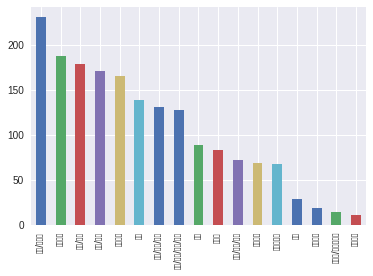

In [18]:
%matplotlib inline 
category_count.plot(kind='bar')

In [0]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df['category_pred'] = df['category'].copy()

In [0]:
df.head()

,article_id,start,end,answered,votes,category,title,content,category_pred
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,일자리


In [20]:
# 첫 번째 인덱스를 가져와 봅니다.
sample_index = df.iloc[0][0]
sample_index

28

In [21]:
sample_title = df['title'][sample_index]
sample_title

'치과위생사 국가고시 날짜 변경 억울합니다'

In [22]:
sample_content = petitions['content'][sample_index]
sample_content

'안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생입니다. 다름이 아니라 너무 억울한\\n일이 생겨  이렇게 글을 적어봅니다. 저희 3학년들은 올해 아주 중요한 시험이  있었습니다.3년동안 힘들게 고생하여 이제곧\\n끝난다.조금만 힘을내자 라는 생각으로 견뎌내고 있었는데 갑자기 어제 과 단톡방의  이내용이 사실이냐면서 한장의 사진을\\n보내주었습니다. 그사진은 국시원에서 올린 공지글을 캡쳐한 사진이였습니다.국시원에서 국가고시 날짜가 변경 되었다.\\n그러니 이글을  널리퍼트려줘라라는 의미를 가진 내용이였습니다. 그내용을 읽고 너무 황당하고 어이가 없어서 국시원쪽으로 전화를 해보니 자신들은 어쩔수없었다 나라에서 그날 공무원 시험을 봐야한다 하루의 2번 국시를 볼수없다\\n그래서 자신들과 보건복지부에서  다시 날짜를 정했는데 그날이 내년 18년 1월 5일이다 라는것입니다.\\n그 말을  듣고 더욱 이해할수가 없었습니다. 먼저 그날 시험을 보기로한 국시생은 저희였는데 갑자기 아무런 말도 문자도\\n없고 그공지글도 그냥 통보였습니다. 국가에서보는 시험이 일반 초중고 수행평가도 아니고 갑자기 이런식으로  바뀐다는게\\n말이 됩니까? 고등학생들이 보는 모의고사,수능도 이런식으로  변경 하지않습니다.  통보로 날짜를 변경하는건  저희\\n에비 의료기사들을 무시하는걸로 보입니다. 저희학교 교수님들은 학생들에게 자부심을 가져라 치과위생사라는 직업을 아끼고 사랑하고 자부심을 가져도 되는 직업이니깐  당당 해져도 괜찮다고  말씀하셨습니다. 하지만 저는  그러지 못할꺼같습니다.  아마 저뿐만이아니라 마음 학생들도 자존심도 낮아지고 무시받는다고 생각했을것입니다.\\n17년 12월16일날의 시험을 봐야하는  국시생들은 저희 예비 치과위생사들 입니다. 공무원 시험이 갑자기 잡혀서  봐야한다면 다른날로 정하는게 맞지않을까요? 먼저 그날의 시험을 보기로 한 학생들은 저희입니다\\n왜 갑자기 저희가 양보해야하고  피해를봐야합니까?  저희국시 앞으로 4달남은상

# 전처리 하기 

In [0]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [0]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [0]:
# 샘플데이터에 적용
pre_sample_content = preprocessing(sample_content)

In [0]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [27]:
pre_sample_content

'안녕하십니까  대통령님 간단하게 제소개 부터 하겠습니다  치위생과  학년 학생입니다  다름이 아니라 너무 억울한 일이 생겨  이렇게 글을 적어봅니다  저희  학년들은 올해 아주 중요한 시험이  있었습니다  년동안 힘들게 고생하여 이제곧 끝난다 조금만 힘을내자 라는 생각으로 견뎌내고 있었는데 갑자기 어제 과 단톡방의  이내용이 사실이냐면서 한장의 사진을 보내주었습니다  그사진은 국시원에서 올린 공지글을 캡쳐한 사진이였습니다 국시원에서 국가고시 날짜가 변경 되었다  그러니 이글을  널리퍼트려줘라라는 의미를 가진 내용이였습니다  그내용을 읽고 너무 황당하고 어이가 없어서 국시원쪽으로 전화를 해보니 자신들은 어쩔수없었다 나라에서 그날 공무원 시험을 봐야한다 하루의  번 국시를 볼수없다 그래서 자신들과 보건복지부에서  다시 날짜를 정했는데 그날이 내년   년   일이다 라는것입니다  말을  듣고 더욱 이해할수가 없었습니다  먼저 그날 시험을 보기로한 국시생은 저희였는데 갑자기 아무런 말도 문자도 없고 그공지글도 그냥 통보였습니다  국가에서보는 시험이 일반 초중고 수행평가도 아니고 갑자기 이런식으로  바뀐다는게 말이 됩니까  고등학생들이 보는 모의고사 수능도 이런식으로  변경 하지않습니다   통보로 날짜를 변경하는건  저희 에비 의료기사들을 무시하는걸로 보입니다  저희학교 교수님들은 학생들에게 자부심을 가져라 치과위생사라는 직업을 아끼고 사랑하고 자부심을 가져도 되는 직업이니깐  당당 해져도 괜찮다고  말씀하셨습니다  하지만  그러지 못할꺼같습니다   아마 저뿐만이아니라 마음 학생들도 자존심도 낮아지고 무시받는다고 생각했을것입니다    년    일날의 시험을 봐야하는  국시생들은 저희 예비 치과위생사들  공무원 시험이 갑자기 잡혀서  봐야한다면 다른날로 정하는게 맞지않을까요  먼저 그날의 시험을 보기로 학생들은 저희입니다 갑자기 저희가 양보해야하고  피해를봐야합니까   저희국시 앞으로  달남은상태였고 지금 학생들이 지쳐지만   월만 참으면 된다 라는 생각으로  견딘 학

In [28]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 134 ms, sys: 0 ns, total: 134 ms
Wall time: 136 ms


In [29]:
%time df['content_preprocessing2'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 306 ms, sys: 909 µs, total: 307 ms
Wall time: 309 ms


# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [0]:
df = df.reindex()

In [31]:
df.shape

(1785, 11)

In [32]:
split_count = int(df.shape[0] * 0.7)
split_count

1249

In [33]:
df_train = df[:split_count].copy()
df_train.shape

(1249, 11)

In [34]:
df_train.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니...
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 저는 치위생과 학년 학생...,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 치위생과 학년 학생입니다...
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,일자리,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...


In [35]:
df_test = df[split_count:].copy()
df_test.shape

(536, 11)

In [36]:
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
159074,195181,2018-04-11,2018-05-11,0,1033,경제민주화,삼성재벌의 노조탄압 진상조사를 위한 청문회개최를 청원합니다.,삼성전자서비스 노조설립 방해에 항의농성중 자살한 노조원의\n죽음을 둘러싼 의혹에 대...,경제민주화,삼성전자서비스 노조설립 방해에 항의농성중 자살한 노조원의 죽음을 둘러싼 의혹에 대하...,삼성전자서비스 노조설립 방해에 항의농성중 자살한 노조원의 죽음을 둘러싼 의혹에 대하...
159216,195377,2018-04-11,2018-05-11,0,1508,보건복지,외국인영주권자 처우 및 복지혜택 개선 관련 청원 取得永住权的在韩外国人待遇 及福利改...,알고 계시나요? 대한민국의 외국인 영주권 납세자 아동 및 노인을 복지 혜택이 없는 ...,보건복지,알고 계시나요 대한민국의 외국인 영주권 납세자 아동 및 노인을 복지 혜택이 없는 ...,알고 계시나요 대한민국의 외국인 영주권 납세자 아동 노인을 복지 혜택이 사실 영...
159218,195379,2018-04-11,2018-05-11,0,1958,안전/환경,퍼스널모빌리티 자전거도로 이용,현재 전동킥보드를 이용하여 출퇴근을 하고 있습니다.\n오늘 자전거도로 출근도중 관할...,안전/환경,현재 전동킥보드를 이용하여 출퇴근을 하고 있습니다 오늘 자전거도로 출근도중 관할 ...,현재 전동킥보드를 이용하여 출퇴근을 오늘 자전거도로 출근도중 관할 경찰서 지구대의...
159505,195778,2018-04-11,2018-05-11,0,4518,행정,이단사이비단체로부터 안전한 대한민국에서 살고 싶습니다.,안녕하세요 저는 김포시에 거주중인 30대초반의 가장입니다.\n제가 이렇게 청원을 드...,행정,안녕하세요 저는 김포시에 거주중인 대초반의 가장입니다 제가 이렇게 청원을 드리...,안녕하세요 김포시에 거주중인 대초반의 가장입니다 제가 이렇게 청원을 드리게된 ...
159650,195997,2018-04-11,2018-05-11,0,1471,보건복지,생리대 무상보급을 요구합니다,생리대는 여성의 필수불가결한 물품입니다.\n약 11세~50세까지 한 달에 한 번 3...,보건복지,생리대는 여성의 필수불가결한 물품입니다 약 세 세까지 한 달에 한 번 ...,생리대는 여성의 필수불가결한 물품입니다 약 세 세까지 달에 번 일을 ...


## 카테고리 

In [37]:
df_train_category_value = pd.DataFrame(df_train['category'].value_counts())
df_train_category_percent = pd.DataFrame(df_train['category'].value_counts(normalize=True))
df_train_category_value.merge(df_train_category_percent, left_index=True, right_index=True)

,category_x,category_y
보건복지,145,0.116093
인권/성평등,140,0.112090
육아/교육,132,0.105685
안전/환경,120,0.096077
정치개혁,105,0.084067
문화/예술/체육/언론,104,0.083267
교통/건축/국토,92,0.073659
기타,90,0.072058
일자리,62,0.049640
행정,57,0.045637


In [38]:
df_test_category_value = pd.DataFrame(df_test['category'].value_counts())
df_test_category_percent = pd.DataFrame(df_test['category'].value_counts(normalize=True))
df_test_category_value.merge(df_test_category_percent, left_index=True, right_index=True)

,category_x,category_y
인권/성평등,91,0.169776
정치개혁,61,0.113806
안전/환경,51,0.095149
기타,49,0.091418
육아/교육,47,0.087687
보건복지,43,0.080224
교통/건축/국토,39,0.072761
행정,32,0.059701
문화/예술/체육/언론,24,0.044776
반려동물,23,0.042910


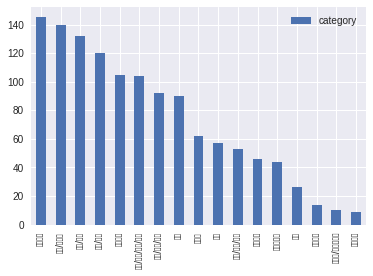

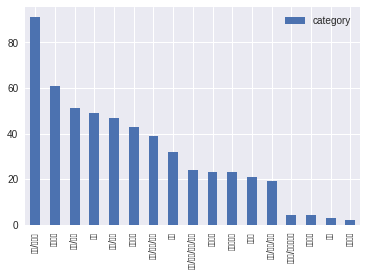

In [39]:
df_train_category_value.plot(kind='bar')
df_test_category_value.plot(kind='bar')

# 단어 벡터화 하기

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [41]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing2'])
train_feature_vector.shape

CPU times: user 4.18 s, sys: 128 ms, total: 4.3 s
Wall time: 4.31 s


In [42]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing2'])
test_feature_vector.shape

CPU times: user 1.64 s, sys: 35.9 ms, total: 1.67 s
Wall time: 1.68 s


In [43]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'and',
 'article',
 'as',
 'be',
 'cctv',
 'co',
 'co kr',
 'co kr news',
 'com']

In [44]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,and,article,as,be,cctv,co,co kr,co kr news,com,...,훨씬,휴게시간,휴게시간을,희망을,힘든,힘들게,힘들어,힘없는,힘을,힘이
0,47,30,61,48,48,19,109,103,51,209,...,27,44,34,73,35,21,21,22,51,28


In [45]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [46]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 6.1 ms, sys: 100 µs, total: 6.2 ms
Wall time: 6.93 ms


In [47]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 3.45 ms, sys: 40 µs, total: 3.49 ms
Wall time: 6.55 ms


In [48]:
test_feature_tfidf.shape

(536, 2000)

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [49]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [50]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
y_label = df_train['category']
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 2.34 s, sys: 16.9 ms, total: 2.36 s
Wall time: 1.29 s


# 학습이 잘 되었는지 평가하기

시험공부에 비유해 보면, (feat.애란쌤)
1. 기출문제를 모은다
2. 공부한다
3. 시험본다

여기에서 2번 단계를 하는 여러 전략이 있을텐데요, 기출문제를 모두 외워버리면 과연 내가 실제 시험을 잘 치룰 수 있을지 아니면 공부를 더 해야할지 판단하기가 애매합니다. 괜찮은 전략 중 하나는 기출문제 중 일부를 임의로 뽑아내서 공부하고(training set을 이용한 학습), 나머지 기출문제를 풀어보며 내가 얼마나 잘 푸는지 평가를 해보는겁니다(validation set을 통해 학습의 성과를 검증). 잘 된다 싶으면 시험을 볼 준비가 된 것입니다(실전 투입).


기출문제를 몽땅 외우면 기출문제 내에서는 100점을 받겠지만(overfitting), 실전에서도 그러한 성적을 가두리라 기대하기 어렵습니다.

In [52]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score = cross_val_score(forest, train_feature_vector, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

CPU times: user 108 ms, sys: 60.1 ms, total: 168 ms
Wall time: 4.57 s


array([0.404     , 0.432     , 0.372     , 0.364     , 0.36144578])

In [53]:
round(np.mean(score)*100,2)

38.67

# 예측

In [54]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(test_feature_vector)
y_pred[:3]

array(['기타', '인권/성평등', '안전/환경'], dtype=object)

In [55]:
y_pred.shape

(536,)

In [56]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output = pd.DataFrame(data={'category_pred':y_pred})
output.head()

,category_pred
0,기타
1,인권/성평등
2,안전/환경
3,문화/예술/체육/언론
4,문화/예술/체육/언론


In [57]:
# 0과 1이 어떻게 집계 되었는지 확인합니다.
# 실제 데이터에는 답변 대상 건이 있는데 없는 것으로 예측되었
output['category_pred'].value_counts()

문화/예술/체육/언론    102
육아/교육           86
보건복지            75
인권/성평등          72
안전/환경           58
정치개혁            44
반려동물            29
기타              22
교통/건축/국토        18
외교/통일/국방        13
일자리              7
경제민주화            6
행정               4
Name: category_pred, dtype: int64

In [0]:
df_test['category_pred'] = y_pred

In [59]:
df_test['pred_diff'] = 0
df_test['pred_diff'] = (df_test['category'] == df_test['category_pred'] ) == 1
df_test['pred_diff'] = df_test['pred_diff'].astype(int)
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,pred_diff
159074,195181,2018-04-11,2018-05-11,0,1033,경제민주화,삼성재벌의 노조탄압 진상조사를 위한 청문회개최를 청원합니다.,삼성전자서비스 노조설립 방해에 항의농성중 자살한 노조원의\n죽음을 둘러싼 의혹에 대...,기타,삼성전자서비스 노조설립 방해에 항의농성중 자살한 노조원의 죽음을 둘러싼 의혹에 대하...,삼성전자서비스 노조설립 방해에 항의농성중 자살한 노조원의 죽음을 둘러싼 의혹에 대하...,0
159216,195377,2018-04-11,2018-05-11,0,1508,보건복지,외국인영주권자 처우 및 복지혜택 개선 관련 청원 取得永住权的在韩外国人待遇 及福利改...,알고 계시나요? 대한민국의 외국인 영주권 납세자 아동 및 노인을 복지 혜택이 없는 ...,인권/성평등,알고 계시나요 대한민국의 외국인 영주권 납세자 아동 및 노인을 복지 혜택이 없는 ...,알고 계시나요 대한민국의 외국인 영주권 납세자 아동 노인을 복지 혜택이 사실 영...,0
159218,195379,2018-04-11,2018-05-11,0,1958,안전/환경,퍼스널모빌리티 자전거도로 이용,현재 전동킥보드를 이용하여 출퇴근을 하고 있습니다.\n오늘 자전거도로 출근도중 관할...,안전/환경,현재 전동킥보드를 이용하여 출퇴근을 하고 있습니다 오늘 자전거도로 출근도중 관할 ...,현재 전동킥보드를 이용하여 출퇴근을 오늘 자전거도로 출근도중 관할 경찰서 지구대의...,1
159505,195778,2018-04-11,2018-05-11,0,4518,행정,이단사이비단체로부터 안전한 대한민국에서 살고 싶습니다.,안녕하세요 저는 김포시에 거주중인 30대초반의 가장입니다.\n제가 이렇게 청원을 드...,문화/예술/체육/언론,안녕하세요 저는 김포시에 거주중인 대초반의 가장입니다 제가 이렇게 청원을 드리...,안녕하세요 김포시에 거주중인 대초반의 가장입니다 제가 이렇게 청원을 드리게된 ...,0
159650,195997,2018-04-11,2018-05-11,0,1471,보건복지,생리대 무상보급을 요구합니다,생리대는 여성의 필수불가결한 물품입니다.\n약 11세~50세까지 한 달에 한 번 3...,문화/예술/체육/언론,생리대는 여성의 필수불가결한 물품입니다 약 세 세까지 한 달에 한 번 ...,생리대는 여성의 필수불가결한 물품입니다 약 세 세까지 달에 번 일을 ...,0


In [60]:
# 맞게 예측한 청원은 1, 틀린 예측은 0으로 표기되었습니다.
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

0    472
1     64
Name: pred_diff, dtype: int64

In [61]:
print('전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[1]))

전체 536건의 데이터 중 64건 예측


In [62]:
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 11.940298507462686


In [63]:
# 제대로 예측한 카테고리 데이터를 봅니다.
predict_correct = df_test.loc[df_test['pred_diff'] == 1]
predict_correct.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,pred_diff
159218,195379,2018-04-11,2018-05-11,0,1958,안전/환경,퍼스널모빌리티 자전거도로 이용,현재 전동킥보드를 이용하여 출퇴근을 하고 있습니다.\n오늘 자전거도로 출근도중 관할...,안전/환경,현재 전동킥보드를 이용하여 출퇴근을 하고 있습니다 오늘 자전거도로 출근도중 관할 ...,현재 전동킥보드를 이용하여 출퇴근을 오늘 자전거도로 출근도중 관할 경찰서 지구대의...,1
159655,196003,2018-04-11,2018-05-11,0,1890,육아/교육,부산 마린시티 해원초등학교 정면 77층 3동 숙박업소 콘도 건립을 불허하라!,부산 마린시티 해원초등학교 인접한 77층 3동 관광숙박업소 콘도 건립은 불허 해야 ...,육아/교육,부산 마린시티 해원초등학교 인접한 층 동 관광숙박업소 콘도 건립은 불허 해야 ...,부산 마린시티 해원초등학교 인접한 층 동 관광숙박업소 콘도 건립은 불허 해야 ...,1
161163,198397,2018-04-13,2018-05-13,0,2421,육아/교육,과학탐구실험 교과의 석차 등급 폐지,과학탐구실험 교과의 석차등급을 폐지하고 성취도 평가만 실시할 수 있도록 해주세요.\...,육아/교육,과학탐구실험 교과의 석차등급을 폐지하고 성취도 평가만 실시할 수 있도록 해주세요 ...,과학탐구실험 교과의 석차등급을 폐지하고 성취도 평가만 실시할 있도록 해주세요 ...,1
166004,205544,2018-04-19,2018-05-19,0,3383,정치개혁,MB아들 이시형과 당시 검사를 처벌해 주십시오,추적 60분을 보는데 너무 화가 나서 국민 청원을 합니다.\n마약공급책과 CF감독 ...,정치개혁,추적 분을 보는데 너무 화가 나서 국민 청원을 합니다 마약공급책과 CF감독 등...,추적 분을 보는데 너무 화가 나서 국민 청원을 마약공급책과 CF감독 이시형 마...,1
168360,208559,2018-04-22,2018-05-22,0,1760,육아/교육,해외거주자도 양육을 하고 있습니다,우리는 대한민국 국민입니다 해외 주재원이란 명목으로 타국에 나와 살고 있지만 우리의...,육아/교육,우리는 대한민국 국민입니다 해외 주재원이란 명목으로 타국에 나와 살고 있지만 우리의...,우리는 대한민국 국민입니다 해외 주재원이란 명목으로 타국에 나와 살고 있지만 우리의...,1


In [64]:
predict_incorrect = df_test.loc[df_test['pred_diff'] == 0].copy()
predict_incorrect.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,pred_diff
159074,195181,2018-04-11,2018-05-11,0,1033,경제민주화,삼성재벌의 노조탄압 진상조사를 위한 청문회개최를 청원합니다.,삼성전자서비스 노조설립 방해에 항의농성중 자살한 노조원의\n죽음을 둘러싼 의혹에 대...,기타,삼성전자서비스 노조설립 방해에 항의농성중 자살한 노조원의 죽음을 둘러싼 의혹에 대하...,삼성전자서비스 노조설립 방해에 항의농성중 자살한 노조원의 죽음을 둘러싼 의혹에 대하...,0
159216,195377,2018-04-11,2018-05-11,0,1508,보건복지,외국인영주권자 처우 및 복지혜택 개선 관련 청원 取得永住权的在韩外国人待遇 及福利改...,알고 계시나요? 대한민국의 외국인 영주권 납세자 아동 및 노인을 복지 혜택이 없는 ...,인권/성평등,알고 계시나요 대한민국의 외국인 영주권 납세자 아동 및 노인을 복지 혜택이 없는 ...,알고 계시나요 대한민국의 외국인 영주권 납세자 아동 노인을 복지 혜택이 사실 영...,0
159505,195778,2018-04-11,2018-05-11,0,4518,행정,이단사이비단체로부터 안전한 대한민국에서 살고 싶습니다.,안녕하세요 저는 김포시에 거주중인 30대초반의 가장입니다.\n제가 이렇게 청원을 드...,문화/예술/체육/언론,안녕하세요 저는 김포시에 거주중인 대초반의 가장입니다 제가 이렇게 청원을 드리...,안녕하세요 김포시에 거주중인 대초반의 가장입니다 제가 이렇게 청원을 드리게된 ...,0
159650,195997,2018-04-11,2018-05-11,0,1471,보건복지,생리대 무상보급을 요구합니다,생리대는 여성의 필수불가결한 물품입니다.\n약 11세~50세까지 한 달에 한 번 3...,문화/예술/체육/언론,생리대는 여성의 필수불가결한 물품입니다 약 세 세까지 한 달에 한 번 ...,생리대는 여성의 필수불가결한 물품입니다 약 세 세까지 달에 번 일을 ...,0
159795,196229,2018-04-12,2018-05-12,0,28729,반려동물,유튜브 고양이 학대범 강력처벌,최근 유튜브에서 한 유튜버가 고양이를 학대하는 영상을찍어 올렸습니다. 이런 범죄를 ...,정치개혁,최근 유튜브에서 한 유튜버가 고양이를 학대하는 영상을찍어 올렸습니다 이런 범죄를 ...,최근 유튜브에서 유튜버가 고양이를 학대하는 영상을찍어 올렸습니다 범죄를 지켜만보아...,0


In [65]:
predict_incorrect_value = predict_incorrect['category'].value_counts()
predict_incorrect_value

인권/성평등         78
정치개혁           51
기타             47
안전/환경          46
교통/건축/국토       38
보건복지           34
행정             32
육아/교육          28
경제민주화          23
문화/예술/체육/언론    22
일자리            21
반려동물           20
외교/통일/국방       19
성장동력            4
저출산/고령화대책       4
미래              3
농산어촌            2
Name: category, dtype: int64

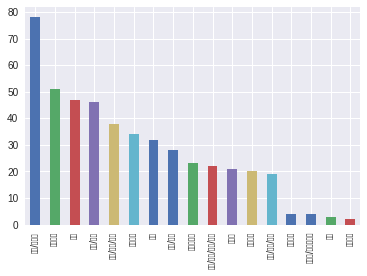

In [66]:
# 잘못 예측한 카테고리 중 인권/성평등 카테고리가 가장 많습니다.
predict_incorrect_value.plot(kind='bar')

# 왜 예측의 정확도가 낮을까요?
* 청원을 입력하는 사람마다 카테고리 분류 기준이 정확하지 않은 것 같습니다.
* 기타로 예측한 분류도 특정 카테고리로 분류해도 될 것으로 보여집니다.

In [67]:
predict_incorrect[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
159074,경제민주화,기타,삼성재벌의 노조탄압 진상조사를 위한 청문회개최를 청원합니다.,삼성전자서비스 노조설립 방해에 항의농성중 자살한 노조원의\n죽음을 둘러싼 의혹에 대...
159216,보건복지,인권/성평등,외국인영주권자 처우 및 복지혜택 개선 관련 청원 取得永住权的在韩外国人待遇 及福利改...,알고 계시나요? 대한민국의 외국인 영주권 납세자 아동 및 노인을 복지 혜택이 없는 ...
159505,행정,문화/예술/체육/언론,이단사이비단체로부터 안전한 대한민국에서 살고 싶습니다.,안녕하세요 저는 김포시에 거주중인 30대초반의 가장입니다.\n제가 이렇게 청원을 드...
159650,보건복지,문화/예술/체육/언론,생리대 무상보급을 요구합니다,생리대는 여성의 필수불가결한 물품입니다.\n약 11세~50세까지 한 달에 한 번 3...
159795,반려동물,정치개혁,유튜브 고양이 학대범 강력처벌,최근 유튜브에서 한 유튜버가 고양이를 학대하는 영상을찍어 올렸습니다. 이런 범죄를 ...
159801,반려동물,안전/환경,"고양이 학대하는 영상 올린 유투버,이 외에도 동물학대범들 처벌 강화 시켜주십시오",한 유투버가 고양이 학대하며 '칼빵하겠다'고 말하고 학대하는 영상을 올렸습니다\n동...
159827,교통/건축/국토,안전/환경,용인시 수지구 동천지구 도시개발사업 원래 계획대로 추진해주시기를 청원합니다,용인시 수지구 동천역세권 개발계획이 용인시와 용인도시공사의 업무태만으로ㅡ 처음 개발...
159921,보건복지,인권/성평등,대한치과위생사협회 회장의 부적절한 방법을 통한 재임을 막아 주세요,저는 많은 사람는들이 치과위생사 가 뭐하는 사람인지 모르는 시절부터 치과위생사로 사...
160122,기타,문화/예술/체육/언론,대한항공 조현민 전무의 갑질을 엄중 처벌해야합니다.,대한항공 조현민의 갑질을 엄중 처벌해야합니다.\n지난번 땅콩회항 사건 당시 조현아의...
160147,교통/건축/국토,육아/교육,대한항공 국적기 박탈해주세요 (조씨 가문 악행 관련),오늘 보도된 조현민 사태를 보고 청원냅니다\n그 유명한 땅콩 회항 사태때 조현아에게...


## 원래 데이터 중 기타로 분류되었으나 분류기가 다르게 예측한 청원을 봅니다.

In [68]:
predict_incorrect_etc = predict_incorrect.loc[predict_incorrect['category'] == '기타'].copy()
predict_incorrect_etc[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
160122,기타,문화/예술/체육/언론,대한항공 조현민 전무의 갑질을 엄중 처벌해야합니다.,대한항공 조현민의 갑질을 엄중 처벌해야합니다.\n지난번 땅콩회항 사건 당시 조현아의...
161075,기타,교통/건축/국토,대한항공 -> 한진항공으로!!,대한은 대한민국을 의미합니다.\n처음 조현아의 땅콩회항 사건 때 실시해야 했습니다....
161370,기타,문화/예술/체육/언론,Kar기 대한항공 의 명칭을 못쓰게 해야됩니다.,금수저출신이라고 갑질하는 대한항공 가족들이\n자기회사가 마치 대한민국을 대표하는것 ...
161671,기타,육아/교육,"‘만민중앙교회’ 등 종교계의 성범죄, 세뇌, 비리, 사기를 밝혀주시고, ‘피해자들’...",존경하고 사랑하는 대통령님!\n어디에도 호소할 수 없던 저희의 이야기를 이렇게 청원...
161913,기타,문화/예술/체육/언론,대한항공 ''대한''상호와 태극문양 사용금지,"안녕하세요,\n조현민 전무의 공개된 음성 파일을\n들었습니다. 직위를 이용해서 그렇..."
162592,기타,보건복지,조씨일가 갑질에 대하여 재수사와 대한한공의 KOREA 라는 단어를 쓰지 못하게 해주세요,과거 조현아의 땅콩회항 사건으로 우리나라는 세계적인 비웃음거리가 되었음에도 불구하고...
164316,기타,행정,다산신도시 택배 사태 해결에 국고가 사용되는 것을 반대합니다.,"다산신도시에서 발생한 택배 배송 거부 사건은\n입주민의 무분별한 님비현상이고, 건설..."
164633,기타,문화/예술/체육/언론,삼성 반도체 공정 정보 공개를 반대합니다.,현재 고용노동부에서 삼성 반도체의 공정 정보 공개를 강행할려고 하는데 이는 다른 나...
165853,기타,인권/성평등,우리들은 머슴입니다.,"KT서비스 남부,북부 , KTIS, KTCS 등 우리 모두는 KT에 의해 만들어진 ..."
167162,기타,보건복지,가짜뉴스를 생산하는 기자와 그 언론사를 처벌해주세요.,가짜 뉴스를 생산해내는 여러 매체와 기자들이 있습니다.\n한 마디로 '아님말고'식으...
